# Gradient Approach

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from utils.edge_extraction import *
import cv2
from utils.feature_extraction import *
from utils.image_conversion import *

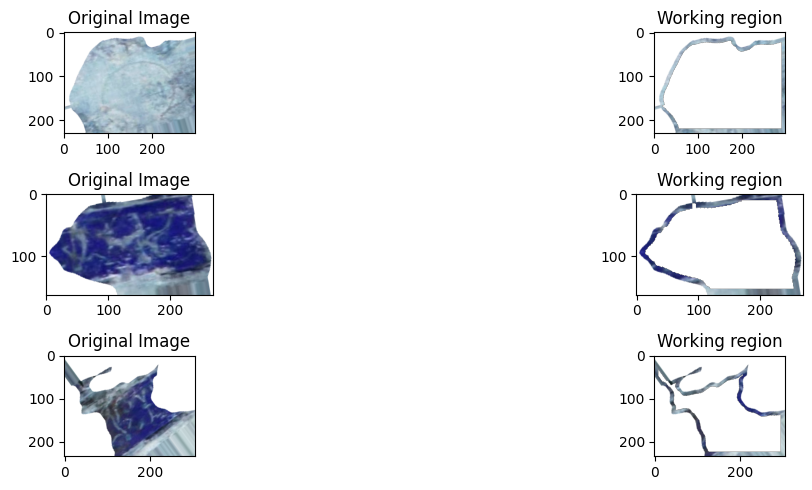

In [2]:
image_green1 = cv2.imread("data/5.1.1.png", cv2.IMREAD_UNCHANGED)
image_green2 = cv2.imread("data/5.1.2.png", cv2.IMREAD_UNCHANGED)
image_yellow = cv2.imread("data/5.1.3.png", cv2.IMREAD_UNCHANGED)

working_region_image_green1 = extract_working_region(image_green1, threshold=10)
working_region_image_green2 = extract_working_region(image_green2, threshold=10)
working_region_image_yellow = extract_working_region(image_yellow, threshold=10)

fig, axes = plt.subplots(3, 2, figsize=(15, 5))
images = [image_green1, working_region_image_green1, image_green2, working_region_image_green2, image_yellow, working_region_image_yellow]
titles = ["Original Image", "Working region"]

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(images[i * 2 + j])
        ax.set_title(titles[j])

plt.tight_layout()
plt.show()

In [3]:
print(image_green1.shape)
print(image_green2.shape)
print(image_yellow.shape)

(229, 299, 4)
(163, 270, 4)
(235, 304, 4)


In [4]:
def get_only_valid_pixels(input_image: np.ndarray) -> np.ndarray:
    # Extract pixels with alpha channel value different from 0
    valid_pixels = input_image[input_image[:, :, 3] != 0]

    # Reshape to (num_pixels, 4)
    reshaped_image = valid_pixels.reshape((-1, 4))

    # Determine the dimensions of the reshaped image
    num_pixels = reshaped_image.shape[0]
    width = int(np.sqrt(num_pixels))
    height = (num_pixels + width - 1) // width

    # Pad the reshaped image to make it rectangular
    padded_image = np.zeros((height * width, 4), dtype=np.uint8)
    padded_image[:num_pixels, :] = reshaped_image

    # Reshape the padded image to the desired dimensions
    final_image = padded_image.reshape((height, width, 4))

    # Split channel
    b, g, r, a = cv2.split(final_image)
    rgb_image = cv2.merge((b, g, r))

    return rgb_image

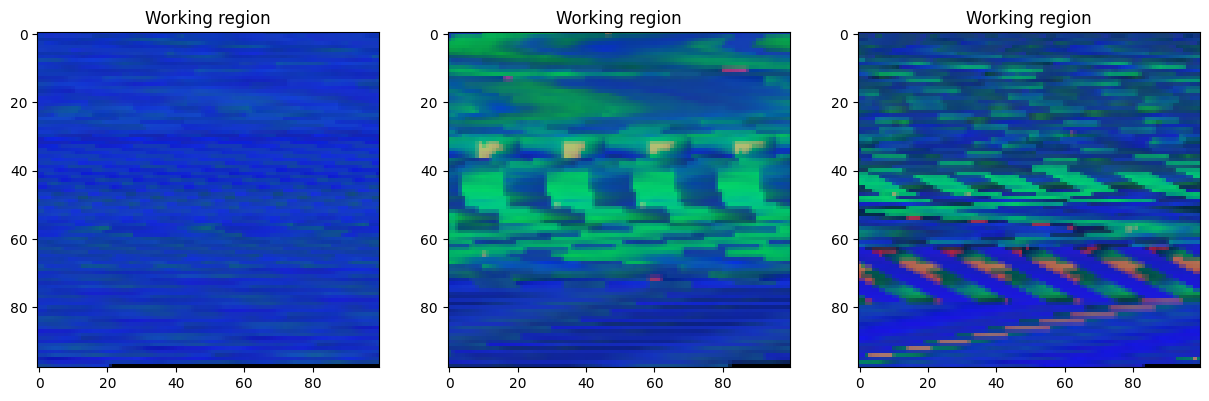

In [5]:
working_region_image_green1 = get_only_valid_pixels(working_region_image_green1)
working_region_image_green2 = get_only_valid_pixels(working_region_image_green2)
working_region_image_yellow = get_only_valid_pixels(working_region_image_yellow)

working_region_image_green1 = cv.cvtColor(working_region_image_green1, cv.COLOR_BGR2HSV)
working_region_image_green2 = cv.cvtColor(working_region_image_green2, cv.COLOR_BGR2HSV)
working_region_image_yellow = cv.cvtColor(working_region_image_yellow, cv.COLOR_BGR2HSV)

max_x = max(working_region_image_green1.shape[0], working_region_image_green2.shape[0], working_region_image_yellow.shape[0])
max_y = max(working_region_image_green1.shape[1], working_region_image_green2.shape[1], working_region_image_yellow.shape[1])

working_region_image_green1 = cv2.resize(working_region_image_green1, (max_x, max_y))
working_region_image_green2 = cv2.resize(working_region_image_green2, (max_x, max_y))
working_region_image_yellow = cv2.resize(working_region_image_yellow, (max_x, max_y))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [working_region_image_green1, working_region_image_green2,working_region_image_yellow]
titles = ["Working region"]

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(titles[0])

plt.show()

In [6]:
print(working_region_image_green1.shape)
print(working_region_image_green2.shape)
print(working_region_image_yellow.shape)

(98, 100, 3)
(98, 100, 3)
(98, 100, 3)


In [7]:
jacobian_yellow = compute_image_gradient(working_region_image_yellow[:,:,:3])
jacobian_yellow

array([[[[ -35. ,  -31. ,  -28. , ...,  -11. ,    7. ,    8. ],
         [ -13. ,  -11.5,  -14.5, ...,    8.5,   10.5,   10. ],
         [   3. ,    4.5,    2. , ...,   14.5,   10.5,   -4.5],
         ...,
         [ -49. ,  -52.5,   -5.5, ...,   -7.5,   -9. ,  -11. ],
         [ -12.5,  -11. ,   -8.5, ...,  -54.5,  -54.5,  -52.5],
         [  58. ,   57. ,   61. , ..., -172. , -169. , -164. ]],

        [[  -4. ,   -3. ,   -3. , ...,  -15. ,   -2. ,   -5. ],
         [  -5. ,   -6. ,   -6. , ...,   -2. ,   -2. ,   -3.5],
         [  -4. ,   -4.5,   -4.5, ...,   10.5,    4. ,   -2. ],
         ...,
         [ -13. ,  -12.5,   -1. , ...,   -3.5,   -1. ,   -4. ],
         [  -3.5,   -1. ,    0.5, ...,   -4.5,  -83. ,   -0.5],
         [  16. ,   16. ,   15. , ...,  -17. ,  -22. ,  -16. ]],

        [[  12. ,    9. ,    9. , ...,  -12. ,  -10. ,  -12. ],
         [   0. ,   -1. ,    2. , ...,   -1.5,   -2. ,    0.5],
         [   5.5,    4.5,    5. , ...,    4.5,    0. ,    4. ],
        

In [8]:
jacobian_green = compute_image_gradient(working_region_image_green1[:,:,:3])
jacobian_green - jacobian_yellow

(2, 4, 98, 100)

In [22]:
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

def create_dataset(img_dir = "./data"):
    
    working_regions = []
    for file in os.listdir(img_dir):    
        if os.path.splitext(file)[1] != ".png":
            continue
        
        image = cv.imread(os.path.join(img_dir, file), cv.IMREAD_UNCHANGED)
        working_region = extract_working_region(image, threshold=5)
        working_regions.append(filter_working_region(working_region))
        
    max_width = max(array.shape[1] for array in working_regions)
    max_height = max(array.shape[0] for array in working_regions)
   
    jacobians = []
    for working_region in working_regions:
        reshaped_working_region = cv.resize(working_region, (max_width, max_height))
        reshaped_working_region = cv.cvtColor(reshaped_working_region, cv.COLOR_BGR2HSV)
        jacobian = compute_image_gradient(reshaped_working_region)
        jacobians.append(jacobian)
        
    matrix_similarity = np.zeros((len(working_regions),len(working_regions)))
    
    for i, jacobian1 in enumerate(tqdm(jacobians, desc="Calculating similarities")):
        gx_r = jacobian1[0][0]
        gx_g = jacobian1[0][1]
        gx_b = jacobian1[0][2]
        gx_gray = jacobian1[0][3]
        gy_r = jacobian1[1][0]
        gy_g = jacobian1[1][1]
        gy_b = jacobian1[1][2]
        gy_gray = jacobian1[1][3]               
        for j, jacobian2 in enumerate(jacobians):
            gx_r_2 = jacobian2[0][0]
            gx_g_2 = jacobian2[0][1]
            gx_b_2 = jacobian2[0][2]
            gx_gray_2 = jacobian2[0][3]
            gy_r_2 = jacobian2[1][0]
            gy_g_2 = jacobian2[1][1]
            gy_b_2 = jacobian2[1][2]
            gy_gray_2 = jacobian2[1][3]
            
            dist_gx_r = pairwise_distances(gx_r, gx_r_2)
            dist_gx_g = pairwise_distances(gx_g, gx_g_2)
            dist_gx_b = pairwise_distances(gx_b, gx_b_2)
            dist_gx_gray = pairwise_distances(gx_gray, gx_gray_2)
            dist_gy_r = pairwise_distances(gy_r, gy_r_2)
            dist_gy_g = pairwise_distances(gy_g, gy_g_2)
            dist_gy_b = pairwise_distances(gy_b, gy_b_2)
            dist_gy_gray = pairwise_distances(gy_gray, gy_gray_2)
            
            mean = np.mean([dist_gx_r, dist_gx_g, dist_gx_b, dist_gx_gray, dist_gy_b, dist_gy_gray, dist_gy_r, dist_gy_g, dist_gy_b])
            
            matrix_similarity[i, j] = mean
        
        
    return matrix_similarity
        

In [23]:
X = create_dataset(img_dir = "./data")
X

Calculating similarities:   1%|▏         | 13/1036 [00:35<46:20,  2.72s/it] 


KeyboardInterrupt: 

array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 3. ,  4. ,  4. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 6. ,  6. ,  6. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ..., -0.5,  0. ,  0. ]])

In [19]:
jacobian_green[1][3].shape

(98, 100)

In [11]:
X = X.reshape(X.shape[0], -1)
X.shape

(1036, 92448)

In [12]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 1036
